# Basic Authentication

You can restrict access to your website or some parts of it by implementing a [username/password authentication](https://kubernetes.github.io/ingress-nginx/examples/auth/basic/). Usernames and passwords are taken from a file created and populated by a password file creation tool. HTTP Basic authentication can also be combined with other access restriction methods, for example restricting access by IP address or geographical location.

## Prerequisites
* [Install Helm](https://github.com/amy88ma/Ingress-Configuration/blob/c9b0e25fc5e3f56bdd695eaa1f8f2712afb32fa7/Deployment/Helm%20install.ipynb)
* [Deploy the Nginx controller](https://github.com/amy88ma/Ingress-Configuration/blob/c9b0e25fc5e3f56bdd695eaa1f8f2712afb32fa7/Deployment/nginx_deployment.ipynb)

## Configure an ingress route
This server will be protected with the basic authentication.  Create the ingress that will expose the application eclwatch: Open a file, with the name of eclwatch-ingress.yaml

In [ ]:
apiVersion: networking.k8s.io/v1
kind: Ingress
metadata:
  name: eclwatch-ingress
  annotations:
    kubernetes.io/ingress.class: nginx
spec:
  rules:
  -  http:
      paths:
      - path: /
        pathType: Prefix
        backend:
         service:
           name: eclwatch
           port: 
             number: 8010

Create the ingress route:

In [ ]:
kubectl apply -f eclwatch-ingress.yaml

You should see something like this:

In [ ]:
ingress.networking.k8s.io/eclwatch-ingress created

To confirm the ingress is created, run the following command:

In [ ]:
kubectl get ingress

You should see something like this:

In [ ]:
NAME               CLASS    HOSTS   ADDRESS          PORTS   AGE
eclwatch-ingress   <none>   *       52.149.242.254   80      57s

Now that you confirmed the application is accessible from outside of cluster, secure it.

# Securing the Application
There are three parts in securing the application: create a password file, secret resource, and adding annotations.

## 1. Create a password file
Use a .htpasswd file to protect eclwatch with a password.  This file will store the username and password.  For the first user, call it user1 and run the following:

This command creates a file named auth in you current directory. The credentials that you entered here will be used to login to the application eclwatch when prompted for username and password. 

In [ ]:
htpasswd -c auth user1

You should be prompted to create a password:

Enter the password for the user. This creates a password for a user named 'user1'.  

In [ ]:
New password: 
Re-type new password:

After creating a password for user1, you should see something like this:

In [ ]:
Adding password for user user1

Show the password added to the file 'auth':

In [ ]:
cat auth

The code in your .htpasswd file will show the encrypted password like this:

In [ ]:
user1:$apr1$PC1H4BhX$T7ji1zY4r.b58y/K8Ay2x1

Run it again (without the -c option) for any other users you want to allow access to the website.

## 2. Create a secret resource
Create a secret resource using credentials file.  It will be referred to in the ingress resource to secure the application.  

The following command will create the secret:

In [ ]:
kubectl create secret generic basic-auth --from-file=auth

You should see something like this:

In [ ]:
secret/basic-auth created

## 3. Configure Ingress rules to secure Service
Secure the service using the secret by adding the annotations to the ingress route created previously:
* Open the file, and named eclwatch-ingress.yaml

In [ ]:
apiVersion: networking.k8s.io/v1
kind: Ingress
metadata:
  name: eclwatch-ingress
  annotations:
    kubernetes.io/ingress.class: "nginx"
    # Specifiying type of authentication: basic 
    nginx.ingress.kubernetes.io/auth-type: basic 
    # name of secret that contains user/passwd definitions
    nginx.ingress.kubernetes.io/auth-secret: basic-auth 
    # message to display with an appropriate context why the authentication is required
    nginx.ingress.kubernetes.io/auth-realm: "Authentication required" 
spec:
  rules:
  -  http:
      paths:
      - path: /
        pathType: Prefix
        # specify the service the request should be forwarded to
        backend:
         service:
           name: eclwatch 
           port:
             number: 8010 

Save this file, then configure the added rules using the following command:

In [ ]:
kubectl apply -f eclwatch-ingress.yaml

You should see something like this:

In [ ]:
ingress.networking.k8s.io/eclwatch-ingress configured

# Test the Ingress rule
Once you have created the new ingress, try to access the same URL by using the following command:

In [ ]:
kubectl get svc -n ingress-nginx

You should see something like this:

In [ ]:
NAME                                 TYPE           CLUSTER-IP     EXTERNAL-IP      PORT(S)                      AGE
ingress-nginx-controller             LoadBalancer   10.0.22.78     52.149.242.254   80:32012/TCP,443:30303/TCP   4m7s

Copy the external IP address, and enter it into a web browser. You are prompted for the username and password, provide the same username and password created in the auth file, and you will successfully be able to access the eclwatch service.

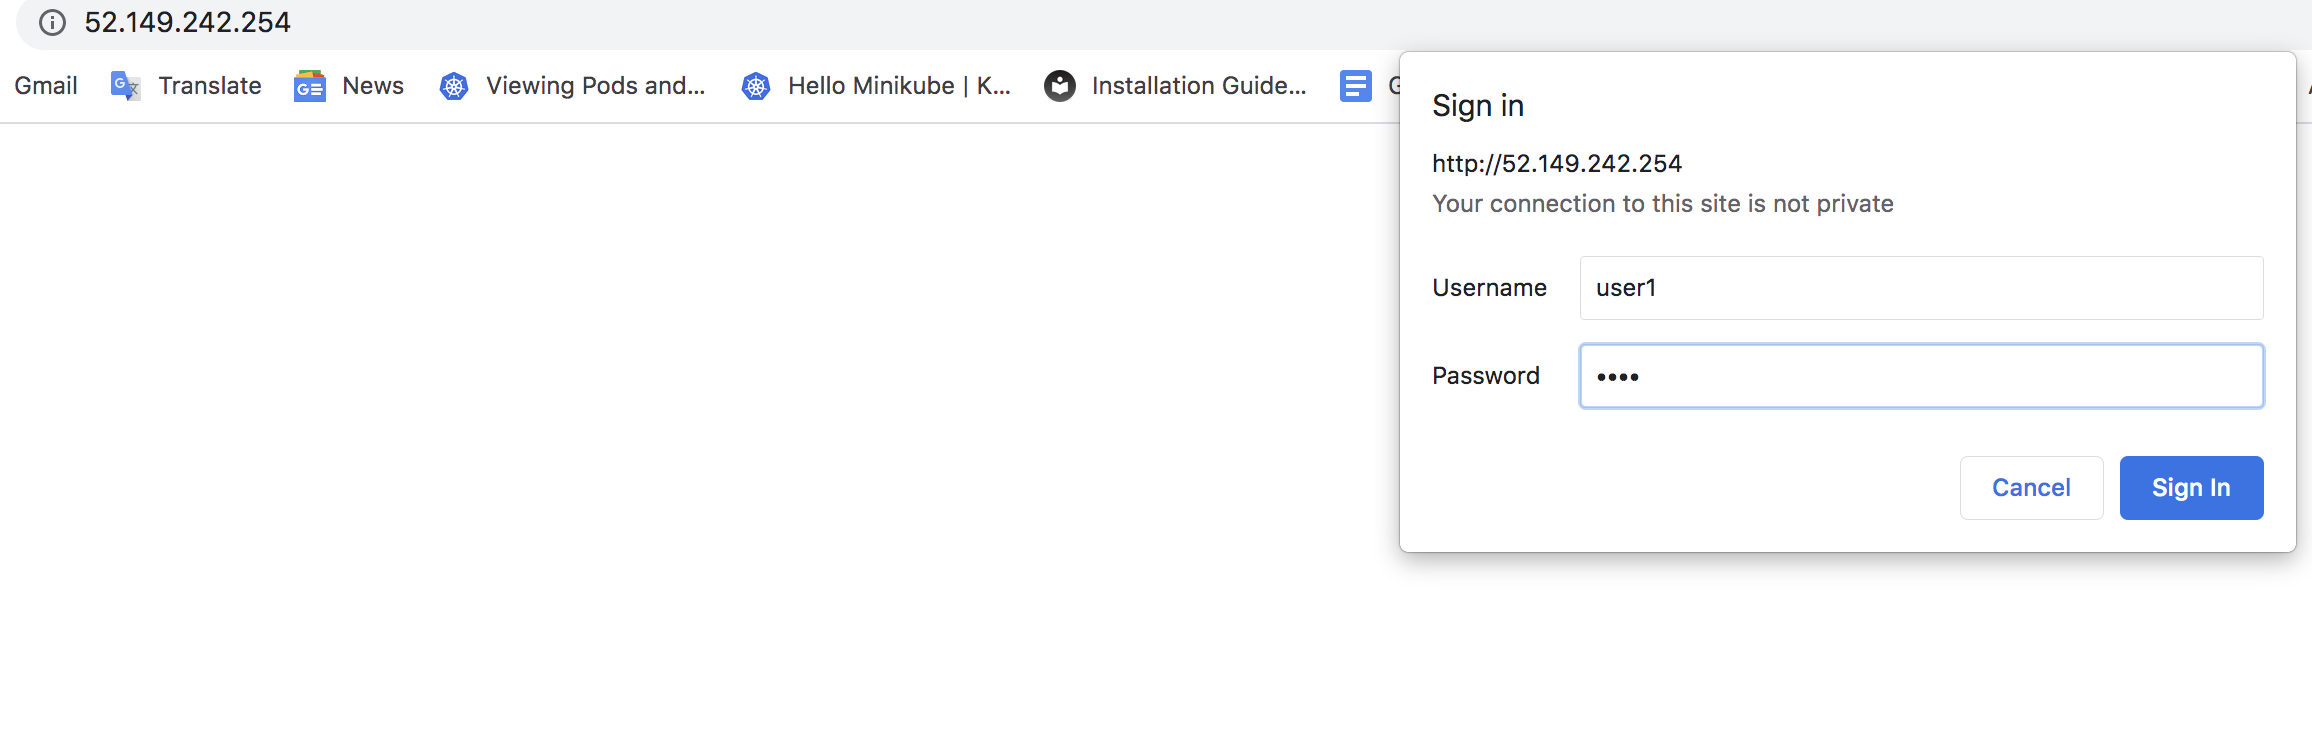

# Additional Annotations
The annotations can be added to the ingress file for more configuration options.

##  Allow access to only specific people (IPs)
Use whitelisting to specify allowed client IP source ranges using the annotation:

In [ ]:
nginx.ingress.kubernetes.io/whitelist-source-range:

The value is a comma separated list of CIDRs, e.g. 10.0.0.0/24,172.10.0.1. When an IP address not specified in the annotation tries to access the IP address, 403 forbidden error is returned.

## Multiple user Authentication
The auth-secret can have two forms:

* auth-file - default, an htpasswd file in the key auth within the secret
* auth-map - the keys of the secret are the usernames, and the values are the hashed passwords

Specify a form using the following annotation:

In [ ]:
nginx.ingress.kubernetes.io/auth-secret-type: [auth-file|auth-map]